In [81]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import pickle
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
from nltk.corpus import wordnet as wn
#nltk.download('wordnet')
#nltk.download('wordnet')
# spacy for lemmatization
import spacy
from spacy.lang.en import English
parser = English()

# Plotting tools


import pandas as pd
import pickle


with open("../data/all_reviews.pkl","rb") as f:
    all_reviews = pickle.load(f)
    
job_filter = pd.read_csv("../data/filter_job_titles.csv")

job_filters = job_filter.clean_job_title.tolist()


In [82]:
idx = (all_reviews.language == "en")
reviews = all_reviews.loc[idx,:]

idx = (reviews.clean_job_title.isin(job_filters))
reviews = reviews.loc[idx,:].reset_index()

print(reviews.shape)
display(reviews.head())

(45251, 16)


,index,company_name,review_title,job_title,employee_status,location,date,review,pros,cons,rating,yes_helpful,no_helpful,industry,clean_job_title,language
0,299,Fluor Corp.,Awesome company,Quality Manager,Former Employee,Afghanistan,2019-10-17,Fluor is a great company with people that care...,NaN,NaN,4.0,0,0,construction,quality manager,en
1,1145,Fluor Corp.,Was a much better company in the 90's,Control Systems Designer,Former Employee,"Sugar Land, TX",2018-06-06,Fluor was the first powerhouse EPC that went h...,Nice Location,They have no work,3.0,2,0,construction,control systems designer,en
2,1375,Fluor Corp.,Enjoyed the Work Environment,Senior Software Developer,Current Employee,"Aliso Viejo, CA",2018-03-08,There is not much that I could add here. I en...,Relaxed Environment,None really,5.0,0,1,construction,software developer,en
3,1874,Fluor Corp.,Good place,System Engineer I,Current Employee,"Piketon, OH",2017-09-15,The place can be pretty boring most of the tim...,NaN,NaN,4.0,0,0,construction,system engineer,en
4,2136,Fluor Corp.,Hurry up and wait,Software Developer I,Current Employee,"Piketon, OH",2017-06-26,"Everyone is in a hurry to get things done, but...",Great healthcare,Located in the middle of no-where,3.0,1,0,construction,software developer,en


In [83]:
import re
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = r"(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"

def split_into_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub(r"\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    
    sentences = [s.strip() for s in sentences]
    sentences = [i for i in sentences if len(i) > 0]
    return sentences

In [84]:
from nltk import word_tokenize
from nltk.corpus import stopwords

company_name = reviews.company_name
company_name = list(set(company_name))

tokens = map(str.lower, company_name)
tokens = map(str.split, tokens)

stop_words = stopwords.words('english')

print("Stop word count", len(stop_words))

for token in tokens:
    stop_words.extend(token[0:1])
    
stop_words = list( set(stop_words) )
stop_words = [x for x in stop_words if x not in ['management','performance','measurement']]
print("Stop word count after adding company names", len(stop_words))

Stop word count 179
Stop word count after adding company names 827


In [85]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
co_reviews = reviews.review.tolist()
def parseSentence(line):
    lmtzr = WordNetLemmatizer()
    text_token = CountVectorizer().build_tokenizer()(line.lower())
    text_rmstop = [i for i in text_token if i not in stop_words]
    text_stem = [lmtzr.lemmatize(w) for w in text_rmstop]
    return " ".join(text_stem)



tech_review_word_corpus = list(map(parseSentence, co_reviews))

tech_review_word_corpus[0]

'great company people care make difference management care employee well providing continued learning opportunity'

In [86]:

# from nltk import sent_tokenize
# from nltk.corpus import stopwords
# import spacy
# import re
from nltk.stem.wordnet import WordNetLemmatizer
co_reviews = reviews.review.tolist()
def parseSentence(line):
    result=[]
    lmtzr = WordNetLemmatizer()
    text_token = split_into_sentences(line.lower())
    for i in range(len(text_token)):
        text_rmstop = [lmtzr.lemmatize(word) for word in re.split(r"\W+",text_token[i]) if word.lower() not in stop_words]
        result.append(' '.join(text_rmstop).strip())
    return result



In [87]:
co_reviews = reviews.review.tolist()

tech_review_sent_corpus = list(map(parseSentence, co_reviews))

In [88]:
reviews.review[0]

'Fluor is a great company with people that care to make a difference.  Management cares about their employees as well as providing them with continued learning opportunities.'

In [89]:
tech_review_sent_corpus[0]

['great company people care make difference',
 'management care employee well providing continued learning opportunity']

In [90]:
indices = reviews["index"].tolist()

corpus = []
for idx, review in zip(indices, tech_review_word_corpus):
    corpus.append({
        "index":idx
        ,"review":review
    })

with open("../data/tech_review_word_corpus.pkl","wb") as f:
    pickle.dump(corpus, f)

len(corpus)

45251

In [91]:
indices = reviews["index"].tolist()

corpus = []
for idx, review in zip(indices, tech_review_sent_corpus):
    for i in range(len(review)):
        corpus.append({
        "index":idx
        ,"review":review[i]
    })

with open("../data/tech_review_sent_corpus.pkl","wb") as f:
    pickle.dump(corpus, f)

len(corpus)

156991

## Neural Network Preperation

* Pretrain a word2vec modle using all 2 million reviews

In [92]:
%%time
from multiprocessing import Pool

idx = (all_reviews.language == "en")
all_reviews = all_reviews.loc[idx,:]

all_co_reviews = all_reviews.review.tolist()

with Pool() as p:
    all_review_sent_corpus = list(p.map(parseSentence, all_co_reviews))


CPU times: user 6.61 s, sys: 5.21 s, total: 11.8 s
Wall time: 4min 33s


In [93]:
%%time

import gensim

sentences = [item.split() for sublist in all_review_sent_corpus for item in sublist]

model = gensim.models.Word2Vec(sentences, size=200, window=10, min_count=5, workers=4)
model.save("../models/w2v_embedding")

CPU times: user 8min 58s, sys: 9.7 s, total: 9min 8s
Wall time: 3min 1s


In [94]:
from scipy.spatial.distance import cosine

print(cosine(model.wv["experince"], model.wv["experience"]))
print(cosine(model.wv["oppurtunity"], model.wv["opportunity"]))


0.3436771631240845
0.20628619194030762


In [95]:
%%time

from collections import Counter

missing = Counter()
vocab = Counter()

for sent in corpus:
    tokens = sent["review"].split()
    for word in tokens:
        if word in model.wv:
            vocab[word]+=1
        else:
            missing[word]+=1
    
print("Total Words Matching", len(vocab))
print("Total Missing Words", len(missing))

Total Words Matching 18544
Total Missing Words 5041
CPU times: user 534 ms, sys: 5.44 ms, total: 540 ms
Wall time: 539 ms


In [96]:
missing.most_common(1000)

[('rgas', 4),
 ('lochbridge', 4),
 ('qdrs', 4),
 ('mozy', 4),
 ('iwcs', 4),
 ('microinfo', 4),
 ('wpp', 3),
 ('webshere', 3),
 ('windbg', 3),
 ('workplacementorsiemens', 3),
 ('dmca', 3),
 ('icas', 3),
 ('innovationmanagement', 3),
 ('1553', 3),
 ('javabeans', 3),
 ('fairpoint', 3),
 ('cmhc', 3),
 ('tsinghua', 3),
 ('facelets', 3),
 ('hql', 3),
 ('jcaps', 3),
 ('vnx2', 3),
 ('touchcommerce', 3),
 ('7600', 3),
 ('practial', 3),
 ('ripv2', 3),
 ('igrp', 3),
 ('mrtg', 3),
 ('ehb', 3),
 ('aow', 3),
 ('citic', 3),
 ('i2b2', 3),
 ('hurrah', 2),
 ('exptin', 2),
 ('gymn', 2),
 ('mariachi', 2),
 ('microstratgey', 2),
 ('huston', 2),
 ('difficlties', 2),
 ('vinings', 2),
 ('sessionbeans', 2),
 ('uncanning', 2),
 ('whimpering', 2),
 ('shruthi', 2),
 ('sapui5', 2),
 ('sfm', 2),
 ('solapur', 2),
 ('learninggreat', 2),
 ('learninggood', 2),
 ('dcom', 2),
 ('win32', 2),
 ('sqlite', 2),
 ('facilitiesgood', 2),
 ('postscript', 2),
 ('wagerworks', 2),
 ('xenmobile', 2),
 ('yearup', 2),
 ('keystore', 2),

In [97]:
with open("../data/glove-tech-revew-vocab.txt", "w") as f:
    for word, ct in vocab.items():
        f.writelines(word + "," + str(ct) + "\n")

In [98]:
for r in corpus:
    if "innovationmanagement" in r["review"]:
        print(r["index"])
        break

1521235


In [99]:
print(reviews.loc[reviews["index"] == 1521235,].review.values)

['No innovationmanagement wants band-aid solutions and do not want to spend $$ of long-term fixes']


Max Character length 1619
Average Character Length 239.12196415548829
Standard Deviation 191.0615365490603
Median Character Length 179.0
Characters 2 standard deviations from mean 621.2450372536089


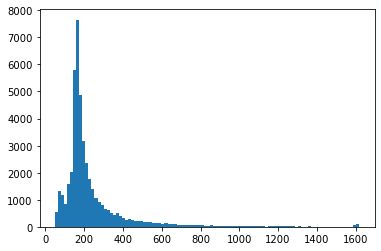

In [100]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
word_length = reviews.review.apply(len).tolist()

print("Max Character length", max(word_length))
print("Average Character Length", np.mean(word_length))
print("Standard Deviation", np.std(word_length))
print("Median Character Length", np.median(word_length))
print("Characters 2 standard deviations from mean", np.mean(word_length) + (2*np.std(word_length)))

plt.hist(word_length,bins=100)
plt.show()